# Homework

## Task 1

Design your on own CNN network and aim for the best in CIFAR-10 classification! 

Try to make your model perform well using the techniques we've discussed before, but don't be too harsh on yourself :）

Your steps should be:

- Load Dataset
- Model Architecture Design
- Model Training Loop
- Testing on CIFAR-10


### Step 1: Load Dataset

In [26]:
# your code here
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim


# CIFAR-10 数据集的下载和加载
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 转换为 Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 归一化
    ]
)

from torch.utils.data import Dataset, DataLoader

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
len(trainset), len(testset)

(50000, 10000)

### Step 2: Model Architecture Design

In [3]:
# your code here
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 卷积层 & 池化层
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1
        )  # 3*32*32 -> 32*32*32
        self.bn1 = nn.BatchNorm2d(num_features=32)  # 批标准化
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32*32*32 -> 32*16*16
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )  # 32*16*16 -> 64*16*16
        self.bn2 = nn.BatchNorm2d(num_features=64)  # 批标准化
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64*16*16 -> 64*8*8

        # 全连接层
        self.fc3 = nn.Linear(in_features=64 * 8 * 8, out_features=256)  # 展平 -> 256
        self.fc4 = nn.Linear(in_features=256, out_features=10)  # 256 -> 10

        # dropout
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        # 卷积 + batchnorm + relu + 池化
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # 全连接 + relu + dropout
        x = x.view(-1, 64 * 8 * 8)  # 展平
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = self.fc4(x)

        return x

### Step 3: Model Training Loop

In [4]:
# your code here
def training_loop(model, trainloader, testloader, optimizer, loss_fn, n_epoch, device):
    # 记录训练过程中训练集和测试集上的损失变化
    train_loss_history = []
    test_loss_history = []

    # 循环训练
    model.train()
    for epoch in range(n_epoch):
        total_loss = 0

        # 遍历训练数据
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            probs = model(images)  # 前向传播
            loss = loss_fn(probs, labels)  # 计算损失
            total_loss += loss.item()
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

        avg_train_loss = total_loss / len(trainloader)
        avg_test_loss, test_accuracy = test(model, testloader, loss_fn, device)
        print(
            f"Epoch[{epoch+1}], Train Loss: {avg_train_loss:.4f},",
            f"Test Loss: {avg_test_loss:.4f},"
            f"Test Accuracy: {(test_accuracy * 100):.2f}%",
        )

        train_loss_history.append(avg_train_loss)
        test_loss_history.append(avg_test_loss)

    # 可视化训练损失和测试损失
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Train and Test Loss")
    plt.show()


def test(model, testloader, loss_fn, device):
    # 记录测试过程中的损失和正确数量
    total_loss = 0
    correct_count = 0
    total_count = 0

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            probs = model(images)  # 模型输出的标签概率分布
            _, predictions = probs.max(dim=1)  # 取最大概率的为预测标签
            loss = loss_fn(probs, labels)  # 计算损失
            total_loss += loss.item()
            correct_count += predictions.eq(labels).sum().item()  # 记录正确的数量
            total_count += labels.shape[0]  # 记录这一批样本的数量

    avg_test_loss = total_loss / len(testloader)
    test_accuracy = correct_count / total_count

    return avg_test_loss, test_accuracy

Epoch[1], Train Loss: 1.6513, Test Loss: 1.3390,Test Accuracy: 53.76%
Epoch[2], Train Loss: 1.2172, Test Loss: 1.1704,Test Accuracy: 58.63%
Epoch[3], Train Loss: 1.0669, Test Loss: 1.0664,Test Accuracy: 62.37%
Epoch[4], Train Loss: 0.9763, Test Loss: 1.0025,Test Accuracy: 64.75%
Epoch[5], Train Loss: 0.9038, Test Loss: 0.9742,Test Accuracy: 65.83%
Epoch[6], Train Loss: 0.8530, Test Loss: 0.9199,Test Accuracy: 67.68%
Epoch[7], Train Loss: 0.8039, Test Loss: 0.9140,Test Accuracy: 67.75%
Epoch[8], Train Loss: 0.7615, Test Loss: 0.8976,Test Accuracy: 68.38%
Epoch[9], Train Loss: 0.7236, Test Loss: 0.8761,Test Accuracy: 69.61%
Epoch[10], Train Loss: 0.6873, Test Loss: 0.8626,Test Accuracy: 70.05%
Epoch[11], Train Loss: 0.6530, Test Loss: 0.8601,Test Accuracy: 70.32%
Epoch[12], Train Loss: 0.6183, Test Loss: 0.8510,Test Accuracy: 70.87%
Epoch[13], Train Loss: 0.5897, Test Loss: 0.8699,Test Accuracy: 69.97%
Epoch[14], Train Loss: 0.5560, Test Loss: 0.8414,Test Accuracy: 71.05%
Epoch[15], Trai

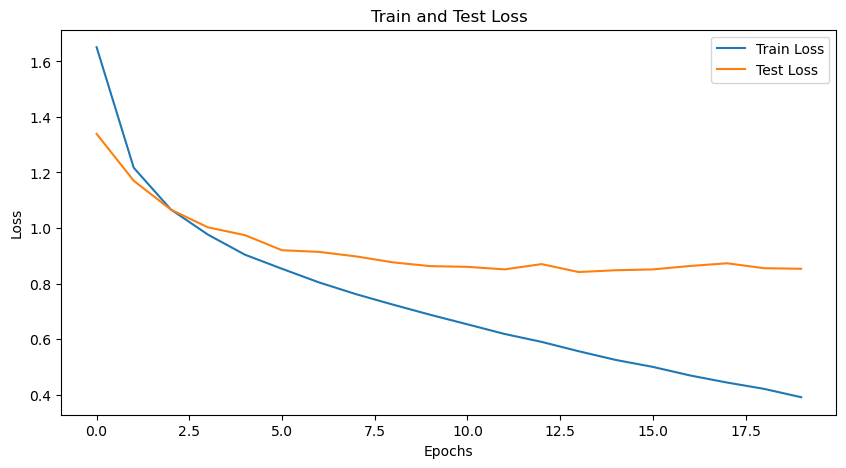

In [27]:
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CNN().to(my_device)
optimizer = optim.Adam(cnn.parameters(), lr=1e-4, weight_decay=1e-4)

training_loop(
    model=cnn,
    trainloader=DataLoader(trainset, batch_size=256, shuffle=True, drop_last=False),
    testloader=DataLoader(testset, batch_size=1024, shuffle=False, drop_last=False),
    optimizer=optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    n_epoch=20,
    device=my_device,
)

### Step 4: Testing on CIFAR-10

In [28]:
# your code here
test_loss, test_acc = test(
    model=cnn,
    testloader=DataLoader(testset, batch_size=1024, shuffle=False, drop_last=False),
    loss_fn=nn.CrossEntropyLoss(),
    device=my_device,
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {(test_acc * 100):.2f}%")

Test Loss: 0.8531, Test Accuracy: 72.06%


## Task 2

After designing your own model，use at least one of the powerful models (AlexNet, VGG, Resnet, etc.) to train on CIFAR-10 to see how well it performs. (Or try more than one if you have time)

In [7]:
import torchvision.models as models
import os

# 模型的本地保存路径
model_dir = "./models"

# 下载模型（含预训练权重）
if not os.path.exists(model_dir) or len(os.listdir(model_dir)) == 0:
    vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    alexnet = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

    # 修改模型的最后一层以适配CIFAR-10
    vgg16.classifier[6] = nn.Linear(4096, 10)
    alexnet.classifier[6] = nn.Linear(4096, 10)
    resnet50.fc = nn.Linear(2048, 10)

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    torch.save(vgg16.state_dict(), f"{model_dir}/vgg16.pth")
    torch.save(alexnet.state_dict(), f"{model_dir}/alexnet.pth")
    torch.save(resnet50.state_dict(), f"{model_dir}/resnet50.pth")

In [23]:
# 新建不含预训练权重的模型
vgg16 = models.vgg16(weights=None).to(my_device)
alexnet = models.alexnet(weights=None).to(my_device)
resnet50 = models.resnet50(weights=None).to(my_device)

# 修改模型的最后一层以适配CIFAR-10
vgg16.classifier[6] = nn.Linear(4096, 10, device=my_device)
alexnet.classifier[6] = nn.Linear(4096, 10, device=my_device)
resnet50.fc = nn.Linear(2048, 10, device=my_device)

# 从本地加载保存的权重
vgg16.load_state_dict(torch.load(f"{model_dir}/vgg16.pth", weights_only=True))
alexnet.load_state_dict(torch.load(f"{model_dir}/alexnet.pth", weights_only=True))
resnet50.load_state_dict(torch.load(f"{model_dir}/resnet50.pth", weights_only=True))

<All keys matched successfully>

根据vgg16，alexnet，resnet50的预训练数据集（ImageNet），重新设置相应的transform并加载数据集

In [9]:
from torchvision import datasets
from torch.utils.data import Subset

# 数据预处理
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # 转化为ImageNet的大小（符合模型输入）
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 归一化（根据ImageNet的特征）
    ]
)

trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

for i, (img, label) in enumerate(trainloader):
    if i > 3:
        break
    print(img.shape)
    print(label.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 3, 224, 224])
torch.Size([64])
torch.Size([64, 3, 224, 224])
torch.Size([64])


In [11]:
len(trainset), len(testset)

(50000, 10000)

由于vgg16，alexnet，resnet50结构较为复杂，而本地算力和显存有限，为加快训练缩小训练集和测试集（仅取10%）

In [12]:
# 缩小数据集
trainset = Subset(trainset, range(5000))
testset = Subset(testset, range(500))  

In [13]:
len(trainset), len(testset)

(5000, 500)

vgg的表现

Epoch[1], Train Loss: 1.7895, Test Loss: 1.3643,Test Accuracy: 70.60%
Epoch[2], Train Loss: 1.1213, Test Loss: 1.0307,Test Accuracy: 73.80%
Epoch[3], Train Loss: 0.8802, Test Loss: 0.8830,Test Accuracy: 75.00%
Epoch[4], Train Loss: 0.7607, Test Loss: 0.8027,Test Accuracy: 76.40%
Epoch[5], Train Loss: 0.6780, Test Loss: 0.7532,Test Accuracy: 75.80%
Epoch[6], Train Loss: 0.6255, Test Loss: 0.7095,Test Accuracy: 76.20%
Epoch[7], Train Loss: 0.5844, Test Loss: 0.6837,Test Accuracy: 78.00%
Epoch[8], Train Loss: 0.5551, Test Loss: 0.6637,Test Accuracy: 77.80%
Epoch[9], Train Loss: 0.5277, Test Loss: 0.6450,Test Accuracy: 78.00%
Epoch[10], Train Loss: 0.5115, Test Loss: 0.6325,Test Accuracy: 77.60%
Epoch[11], Train Loss: 0.4883, Test Loss: 0.6198,Test Accuracy: 78.60%
Epoch[12], Train Loss: 0.4727, Test Loss: 0.6116,Test Accuracy: 79.00%
Epoch[13], Train Loss: 0.4576, Test Loss: 0.6043,Test Accuracy: 78.80%
Epoch[14], Train Loss: 0.4459, Test Loss: 0.5938,Test Accuracy: 78.80%
Epoch[15], Trai

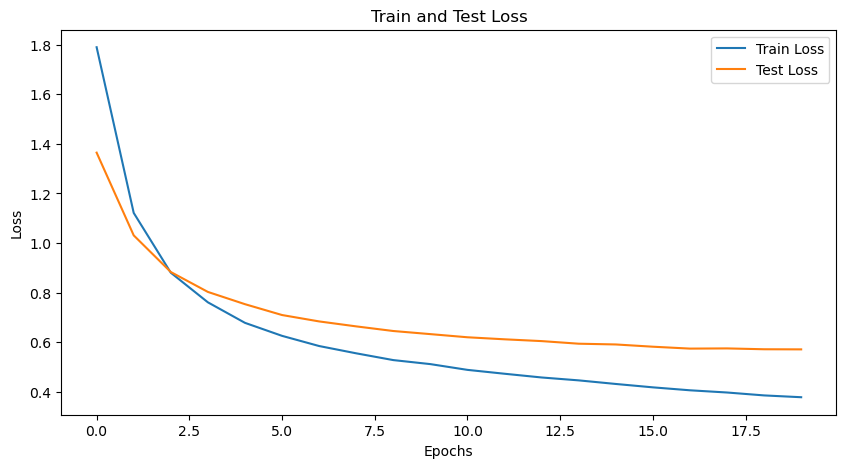

In [14]:
# 冻结卷积层参数，只训练全连接层（迁移学习）
for param in vgg16.features.parameters():
    param.requires_grad = False

optimizer = optim.Adam(params=vgg16.classifier[6].parameters(), lr=1e-4)

training_loop(
    model=vgg16,
    trainloader=DataLoader(trainset, batch_size=64, shuffle=True),
    testloader=DataLoader(testset, batch_size=64, shuffle=False),
    optimizer=optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    n_epoch=20,
    device=my_device,
)

alexnet的表现

In [15]:
# 冻结卷积层参数，只训练全连接层（迁移学习）
for param in alexnet.features.parameters():
    param.requires_grad = False

# for param in alexnet.classifier[6].parameters():
#     param.requires_grad = True

for name, param in alexnet.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

features.0.weight: requires_grad=False
features.0.bias: requires_grad=False
features.3.weight: requires_grad=False
features.3.bias: requires_grad=False
features.6.weight: requires_grad=False
features.6.bias: requires_grad=False
features.8.weight: requires_grad=False
features.8.bias: requires_grad=False
features.10.weight: requires_grad=False
features.10.bias: requires_grad=False
classifier.1.weight: requires_grad=True
classifier.1.bias: requires_grad=True
classifier.4.weight: requires_grad=True
classifier.4.bias: requires_grad=True
classifier.6.weight: requires_grad=True
classifier.6.bias: requires_grad=True


Epoch[1], Train Loss: 2.1737, Test Loss: 1.8279,Test Accuracy: 43.60%
Epoch[2], Train Loss: 1.5852, Test Loss: 1.4449,Test Accuracy: 59.20%
Epoch[3], Train Loss: 1.2665, Test Loss: 1.2335,Test Accuracy: 64.80%
Epoch[4], Train Loss: 1.0846, Test Loss: 1.1096,Test Accuracy: 66.60%
Epoch[5], Train Loss: 0.9672, Test Loss: 1.0289,Test Accuracy: 68.00%
Epoch[6], Train Loss: 0.8850, Test Loss: 0.9698,Test Accuracy: 68.60%
Epoch[7], Train Loss: 0.8261, Test Loss: 0.9261,Test Accuracy: 69.80%
Epoch[8], Train Loss: 0.7789, Test Loss: 0.8898,Test Accuracy: 69.80%
Epoch[9], Train Loss: 0.7377, Test Loss: 0.8605,Test Accuracy: 70.40%
Epoch[10], Train Loss: 0.7067, Test Loss: 0.8360,Test Accuracy: 71.40%
Epoch[11], Train Loss: 0.6796, Test Loss: 0.8172,Test Accuracy: 71.80%
Epoch[12], Train Loss: 0.6531, Test Loss: 0.7971,Test Accuracy: 73.00%
Epoch[13], Train Loss: 0.6285, Test Loss: 0.7806,Test Accuracy: 73.60%
Epoch[14], Train Loss: 0.6101, Test Loss: 0.7690,Test Accuracy: 72.60%
Epoch[15], Trai

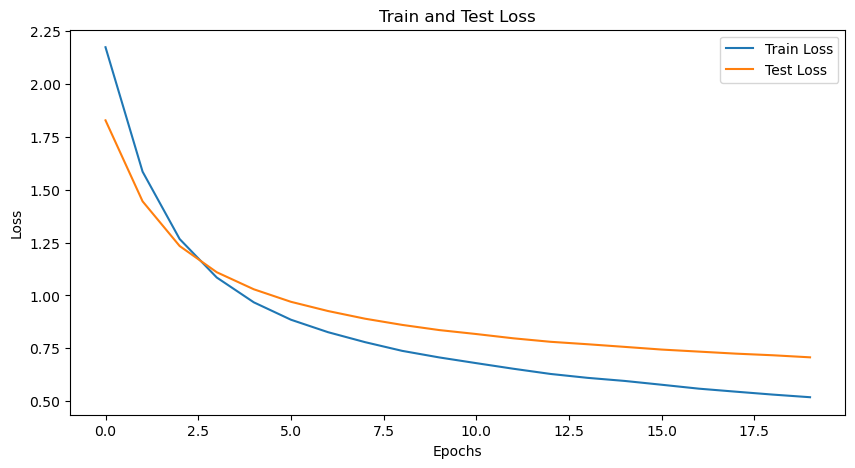

In [16]:
# 冻结卷积层参数，只训练全连接层（迁移学习）
for param in alexnet.features.parameters():
    param.requires_grad = False

optimizer = optim.Adam(params=alexnet.classifier[6].parameters(), lr=1e-4)

training_loop(
    model=alexnet,
    trainloader=DataLoader(trainset, batch_size=256, shuffle=True),
    testloader=DataLoader(testset, batch_size=512, shuffle=False),
    optimizer=optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    n_epoch=20,
    device=my_device,
)

resnet50的表现

Epoch[1], Train Loss: 2.0897, Test Loss: 1.8797,Test Accuracy: 53.60%
Epoch[2], Train Loss: 1.6825, Test Loss: 1.5643,Test Accuracy: 64.60%
Epoch[3], Train Loss: 1.4130, Test Loss: 1.3662,Test Accuracy: 67.40%
Epoch[4], Train Loss: 1.2348, Test Loss: 1.2258,Test Accuracy: 70.80%
Epoch[5], Train Loss: 1.1142, Test Loss: 1.1284,Test Accuracy: 70.00%
Epoch[6], Train Loss: 1.0198, Test Loss: 1.0547,Test Accuracy: 72.80%
Epoch[7], Train Loss: 0.9508, Test Loss: 1.0000,Test Accuracy: 73.20%
Epoch[8], Train Loss: 0.8980, Test Loss: 0.9569,Test Accuracy: 74.20%
Epoch[9], Train Loss: 0.8500, Test Loss: 0.9191,Test Accuracy: 74.20%
Epoch[10], Train Loss: 0.8090, Test Loss: 0.8906,Test Accuracy: 73.80%
Epoch[11], Train Loss: 0.7871, Test Loss: 0.8619,Test Accuracy: 74.40%
Epoch[12], Train Loss: 0.7560, Test Loss: 0.8417,Test Accuracy: 74.80%
Epoch[13], Train Loss: 0.7373, Test Loss: 0.8228,Test Accuracy: 73.40%
Epoch[14], Train Loss: 0.7126, Test Loss: 0.8078,Test Accuracy: 75.00%
Epoch[15], Trai

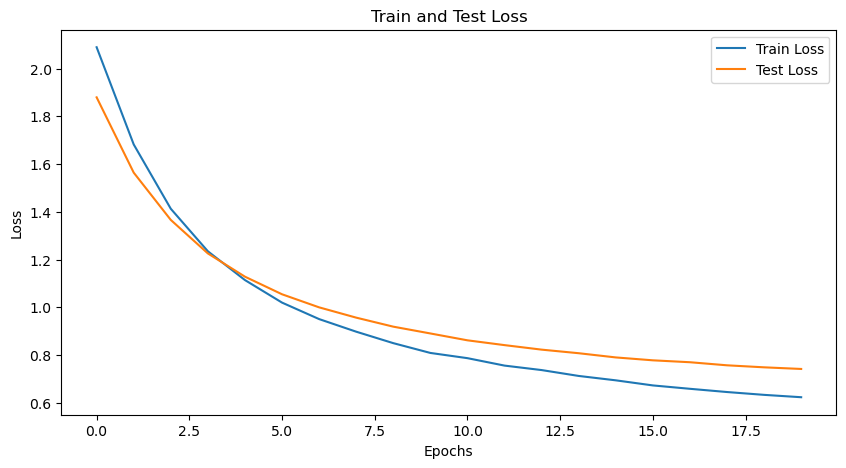

In [24]:
# 冻结卷积层参数，只训练全连接层（迁移学习）
for param in resnet50.parameters():
    param.requires_grad = False

for param in resnet50.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=1e-4)

training_loop(
    model=resnet50,
    trainloader=DataLoader(trainset, batch_size=64, shuffle=True),
    testloader=DataLoader(testset, batch_size=64, shuffle=False),
    optimizer=optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    n_epoch=20,
    device=my_device,
)